In [37]:
import pandas as pd
from pathlib import Path
from fastai.tabular.all import *

seed = 3

# python RNG
import random
random.seed(seed)

# pytorch RNGs
import torch
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

# numpy RNG
import numpy as np
np.random.seed(seed)
from sklearn.metrics import brier_score_loss, auc, roc_curve, roc_auc_score
from math import sqrt
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder

In [38]:
import fastai

In [39]:
fastai.__version__

'2.5.2'

In [40]:
data = pd.read_csv(r'/home/kchen/Documents/leak/new_leak/clean_col.csv', index_col='CASEID')

cat_names = ['CPT', 'SEX', 'FNSTATUS2', 'ASACLAS', 'STEROID', 'ASCITES', 'PRSEPIS', 
             'VENTILAT', 'DIABETES', 'HYPERMED', 'HXCHF', 'DYSPNEA', 'SMOKE', 'HXCOPD', 
             'DIALYSIS', 'RENAFAIL', 'OPERYR', 
             'WNDCLAS', 'RACE_NEW','ETHNICITY_HISPANIC',
              'BLEEDDIS', 'WTLOSS', 'TRANSFUS', 'TRANST',
             'SSSIPATOS', 'DSSIPATOS', 'OSSIPATOS', 'PNAPATOS', 'VENTPATOS', 'UTIPATOS', 'SEPSISPATOS', 'SEPSHOCKPATOS',
             'COL_INDICATION', 'COL_EMERGENT', 'COL_STEROID', 'COL_MECH_BOWEL_PREP', 'COL_ORAL_ANTIBIOTIC', 'COL_CHEMO','COL_APPROACH','OTHBLEED'
            ]
cont_names = ['HEIGHT', 'WEIGHT', 'AGE', 'BMI', 'PRSODM', 'PRBUN', 'PRCREAT', 'PRWBC', 'PRHCT', 'PRPLATE']
y_names=['COL_ANASTOMOTIC']

In [41]:
col_list = []
for col in data.columns:
    if len(data[col].unique()) > 50:
        col_list.append(col)
col_list

['COL_ICD9_INDICATION',
 'COL_ICD9_EMERGENT',
 'AGE',
 'WEIGHT',
 'PRSODM',
 'PRBUN',
 'PRCREAT',
 'PRWBC',
 'PRHCT',
 'PRPLATE',
 'OPTIME',
 'HTOODAY',
 'COL_ICD10_INDICATION',
 'COL_ICD10_EMERGENT',
 'BMI']

In [42]:
data.shape

(194654, 64)

In [43]:
cont_names = ['HEIGHT', 'WEIGHT', 'BMI', 'AGE', 'PRSODM', 'PRBUN', 'PRCREAT', 'PRWBC', 'PRHCT', 'PRPLATE','OPTIME','HTOODAY']

In [44]:
cat_names = [i for i in data.columns if i not in cont_names and i != 'COL_ANASTOMOTIC']

In [45]:
y_name = ['COL_ANASTOMOTIC']

features = cat_names + cont_names + y_names
lrdata = data[features]



num_imputer = SimpleImputer(strategy = 'median')

# Imputation for numeric:
for ncol in cont_names:
    lrdata[ncol] = num_imputer.fit_transform(lrdata[ncol].values.reshape(-1, 1))
le=LabelEncoder()
for col in cat_names:
    lrdata[col] = le.fit_transform(lrdata[col].astype(str))
lrdata['COL_ANASTOMOTIC'] = le.fit_transform(lrdata['COL_ANASTOMOTIC'])
lrdata['COL_ANASTOMOTIC'].value_counts()

data = pd.read_csv(r'/home/kchen/Documents/leak/colleak/clean_col.csv', index_col='CASEID')

In [46]:
trn, tst = RandomSplitter(valid_pct=0.2, seed=seed)(range_of(data))
test = data.iloc[tst, :]
y_test = test['COL_ANASTOMOTIC']
X_test = test.drop(['COL_ANASTOMOTIC'], axis=1)
y_test.shape

(38930,)

In [47]:
data = data.iloc[trn, :]
data.shape

(155724, 64)

In [48]:
data.columns

Index(['COL_STEROID', 'COL_MECH_BOWEL_PREP', 'COL_ORAL_ANTIBIOTIC',
       'COL_CHEMO', 'COL_INDICATION', 'COL_ICD9_INDICATION', 'COL_EMERGENT',
       'COL_ICD9_EMERGENT', 'COL_APPROACH', 'COL_ANASTOMOTIC', 'SEX',
       'PRNCPTX', 'CPT', 'WORKRVU', 'INOUT', 'TRANST', 'AGE', 'OPERYR',
       'ANESTHES', 'SURGSPEC', 'ELECTSURG', 'HEIGHT', 'WEIGHT', 'DIABETES',
       'SMOKE', 'DYSPNEA', 'FNSTATUS2', 'VENTILAT', 'HXCOPD', 'ASCITES',
       'HXCHF', 'HYPERMED', 'RENAFAIL', 'DIALYSIS', 'DISCANCR', 'WNDINF',
       'STEROID', 'WTLOSS', 'BLEEDDIS', 'TRANSFUS', 'PRSEPIS', 'PRSODM',
       'PRBUN', 'PRCREAT', 'PRWBC', 'PRHCT', 'PRPLATE', 'EMERGNCY', 'WNDCLAS',
       'ASACLAS', 'OPTIME', 'HTOODAY', 'SSSIPATOS', 'DSSIPATOS', 'OSSIPATOS',
       'PNAPATOS', 'VENTPATOS', 'UTIPATOS', 'SEPSISPATOS', 'SEPSHOCKPATOS',
       'COL_ICD10_INDICATION', 'COL_ICD10_EMERGENT', 'BMI', 'RACE'],
      dtype='object')

def evaluate(model1, X, y):
    ppreds = model1.predict_proba(X)
    ppreds = ppreds[:,1]
    pscore = roc_auc_score(y, ppreds)
    print('AUC', pscore)


y = data['COL_ANASTOMOTIC']
X = data.drop(['COL_ANASTOMOTIC'], axis=1)
y_test = test['COL_ANASTOMOTIC']
X_test = test.drop(['COL_ANASTOMOTIC'], axis=1)

pd.options.display.max_rows = 100
pd.options.display.max_columns = 200

X.head()

model3 = LogisticRegression(max_iter=1000)
model3.fit(X, y)
evaluate(model3,X_test, y_test)

In [49]:
splits = RandomSplitter(seed=seed, valid_pct=0.25)(range_of(data))
procs = [Categorify, FillMissing, Normalize]
pd.options.mode.chained_assignment=None

In [50]:
to = TabularPandas(data, procs, cat_names, cont_names, y_names=y_name, y_block=CategoryBlock(), splits=splits, inplace=True, reduce_memory=False)
dls = to.dataloaders(1024)

In [51]:
learn = tabular_learner(dls, layers=[1000, 500], 
                        metrics=[RocAucBinary(), BalancedAccuracy(), Precision(), Recall()])

/home/kchen/.local/lib/python3.9/site-packages/fastai/callback/schedule.py:269: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


SuggestedLRs(valley=0.0003311311302240938)

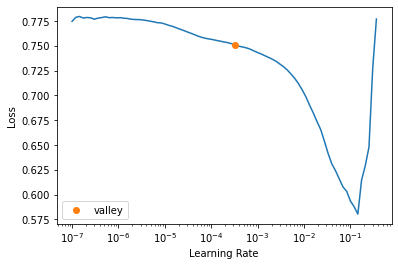

In [52]:
learn.lr_find()

In [53]:
learn.fit_one_cycle(100, 3e-3, wd=0.2, cbs=EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0001, patience=5))

epoch,train_loss,valid_loss,roc_auc_score,balanced_accuracy_score,precision_score,recall_score,time
0,0.644376,0.602929,0.547705,0.533283,0.047989,0.219531,00:25
1,0.492005,0.404708,0.556003,0.505746,0.077844,0.019682,00:24
2,0.283645,0.211035,0.566897,0.501560,0.166667,0.003785,00:24
3,0.172502,0.155246,0.574524,0.503194,0.360000,0.006813,00:25
4,0.145068,0.156869,0.610338,0.510961,0.169082,0.026495,00:24
5,0.143666,0.152812,0.603618,0.501766,0.136364,0.004542,00:24
6,0.141413,0.160802,0.607392,0.509673,0.166667,0.023467,00:23
7,0.138168,0.155680,0.638794,0.509135,0.152284,0.022710,00:23
8,0.136352,0.152711,0.610634,0.506500,0.267606,0.014383,00:23
9,0.134494,0.148639,0.638978,0.510803,0.306931,0.023467,00:23


No improvement since epoch 13: early stopping


In [54]:
dl = learn.dls.test_dl(test)

In [55]:
preds = learn.get_preds(dl=dl)
fapreds = preds[0][:, 1]

In [56]:

from math import sqrt

def roc_auc_ci(y_true, y_score, positive=1):
    AUC = roc_auc_score(y_true, y_score)
    N1 = sum(y_true == positive)
    N2 = sum(y_true != positive)
    Q1 = AUC / (2 - AUC)
    Q2 = 2*AUC**2 / (1 + AUC)
    SE_AUC = sqrt((AUC*(1 - AUC) + (N1 - 1)*(Q1 - AUC**2) + (N2 - 1)*(Q2 - AUC**2)) / (N1*N2))
    lower = AUC - 1.96*SE_AUC
    upper = AUC + 1.96*SE_AUC
    if lower < 0:
        lower = 0
    if upper > 1:
        upper = 1
    return (lower, AUC, upper)

In [57]:
roc_auc_ci(y_test, fapreds, positive=1)

(0.5777899547114329, 0.5942851287308772, 0.6107803027503216)

In [22]:
y_names_long=['Anastomotic leak']

In [23]:
roc_values=[]
l,AUC,h = roc_auc_ci(y_test, fapreds, positive=1)
roc_values.append(AUC)


In [24]:
from collections import OrderedDict
d=dict(list(enumerate(roc_values)))
dd = OrderedDict(sorted(d.items(), key=lambda x: x[1], reverse=True))
roc_ordered=dd.keys()

In [25]:
fpr = dict()
tpr = dict()
roc_auc = dict()
y_names=learn.dls.y_names
n_classes=len(y_names)
roc_values=[]

fpr[0], tpr[0], _ = roc_curve(y_test, fapreds)
roc_auc[0] = auc(fpr[0], tpr[0])
roc_values.append(roc_auc[0])

In [26]:
col_fpr = fpr[0]
col_tpr = tpr[0]

In [27]:
%store col_fpr

Stored 'col_fpr' (ndarray)


In [28]:
%store col_tpr

Stored 'col_tpr' (ndarray)


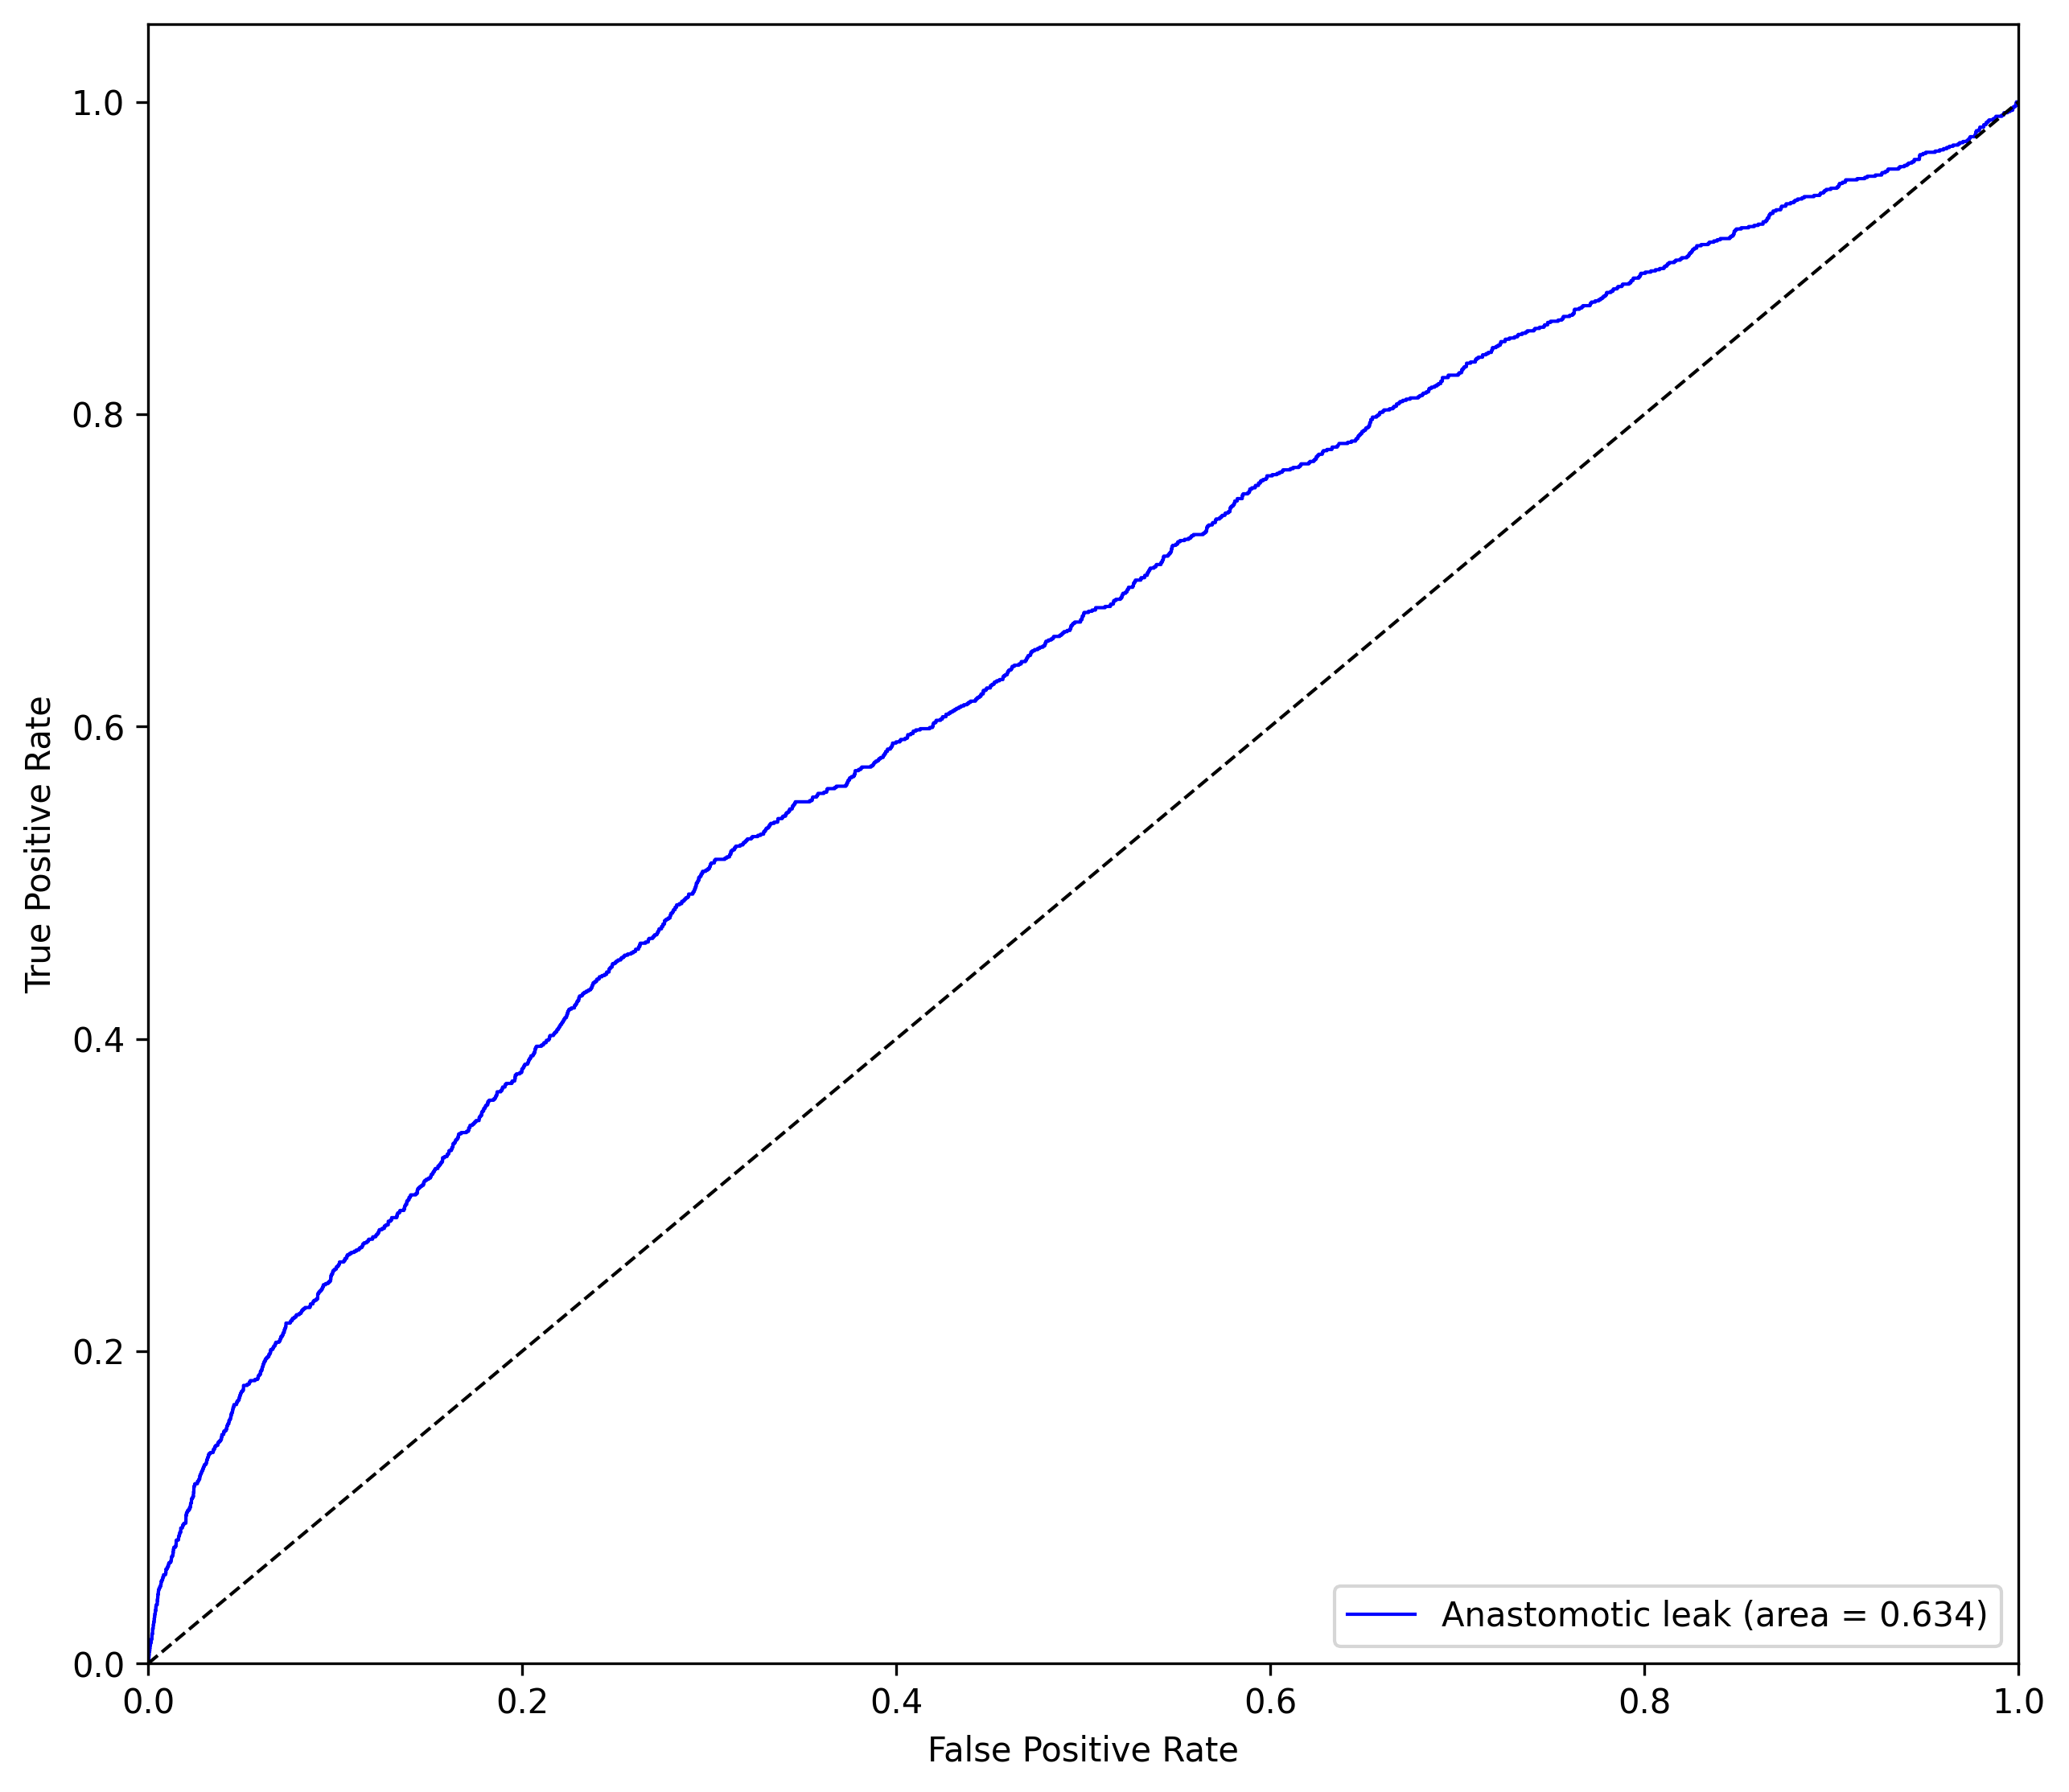

In [29]:
plt.figure(num=None, figsize=(10, 9), dpi=300, facecolor='w', edgecolor='k')

i = 0
plt.plot(fpr[i], tpr[i], color='blue', lw=1,
label=y_names_long[i]+' (area = {1:0.3f})'''.format(i, roc_auc[i]))
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.savefig('ROC_model_1.pdf', bbox_inches='tight')

In [30]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_test, fapreds)

In [31]:
col_prec = precisions
col_rec = recalls

In [32]:
%store col_prec
%store col_rec

Stored 'col_prec' (ndarray)
Stored 'col_rec' (ndarray)


In [33]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, fapreds)
pr_auc = auc(recalls, precisions)

In [34]:
pr_auc

0.07271369067029618

In [35]:
from math import sqrt

def prc_auc_ci(y_true, y_score, positive=1):
    AUC = average_precision_score(y_true, y_score)
    N1 = sum(y_true == positive)
    N2 = sum(y_true != positive)
    Q1 = AUC / (2 - AUC)
    Q2 = 2*AUC**2 / (1 + AUC)
    SE_AUC = sqrt((AUC*(1 - AUC) + (N1 - 1)*(Q1 - AUC**2) + (N2 - 1)*(Q2 - AUC**2)) / (N1*N2))
    lower = AUC - 1.96*SE_AUC
    upper = AUC + 1.96*SE_AUC
    if lower < 0:
        lower = 0
    if upper > 1:
        upper = 1
    return (lower, AUC, upper)
prc_auc_ci(y_test, fapreds, positive=1)

(0.06907315782595626, 0.07319310019739424, 0.07731304256883222)

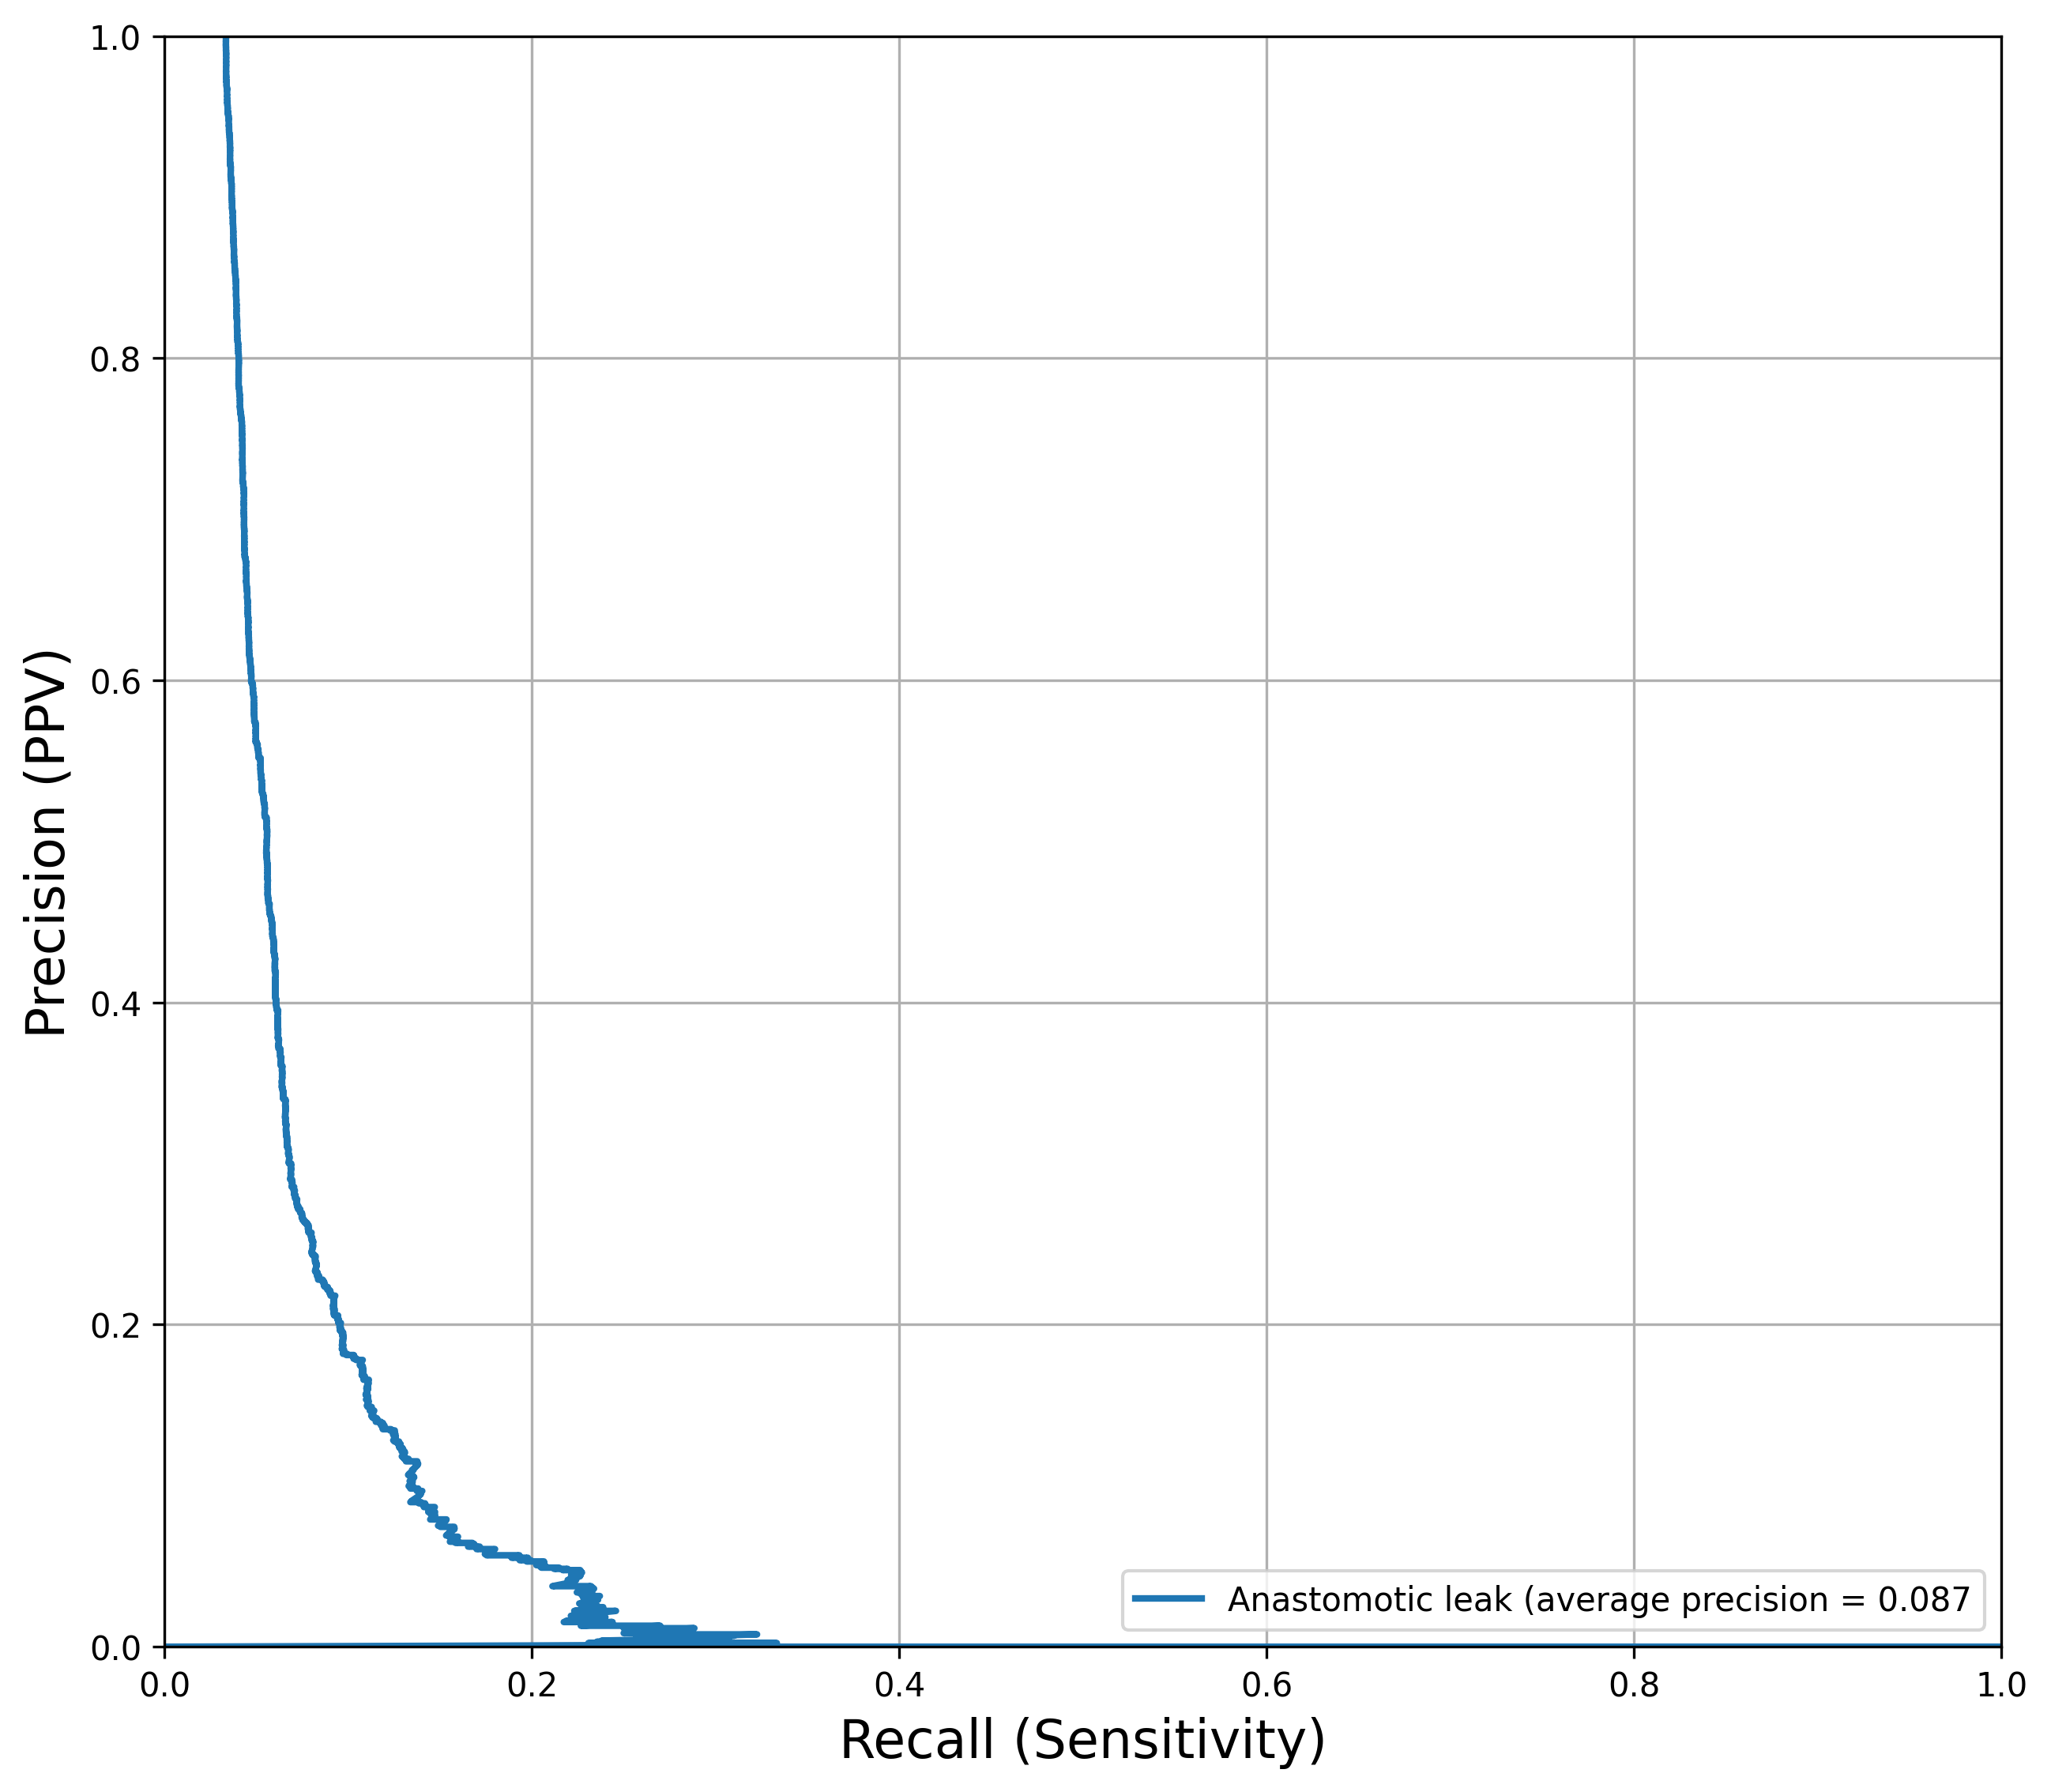

<Figure size 576x432 with 0 Axes>

In [36]:
plt.figure(num=None, figsize=(10, 9), dpi=300, facecolor='w', edgecolor='k')
plt.plot(precisions, recalls, linewidth=2, label=('Anastomotic leak (average precision = 0.087'))
plt.legend(loc="lower right")
plt.axis([0, 1, 0, 1])                                    # Not shown in the book
plt.xlabel('Recall (Sensitivity)', fontsize=16) # Not shown
plt.ylabel('Precision (PPV)', fontsize=16)    # Not shown
plt.grid(True)                                            # Not shown
plt.figure(figsize=(8, 6))                                    # Not shown
plt.show()